# Customer Segmentation

## Introduction
This notebook attempts to create customer segments in order to better understand the type of customers that a company has, as well as build a dataset that can be used by machine learning models.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np;
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_rel, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.cluster import KMeans

## Import Data

This workbook uses data from provided by Gus Segura. More information about this dataset can be found here (https://www.kaggle.com/kyanyoga/sample-sales-data)

In [2]:
data = pd.read_csv('sales_data_sample.csv',encoding='cp1252')

## Data Exploration

In [3]:
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [4]:
data.columns

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')

First, we'll remove unnecessary columns. We'll keep the following columns:
1. SALES
2. ORDERDATE: we can turn this into a time series to plot performance over time later
3. PRODUCTLINE: we might want to compare how different products perform. We can also use the purchasing habits of different products to characterize our customers
4. PRODUCTCODE: similar reasons as above
5. COUNTRY: similar reasons as above
6. DEALSIZE: we can potentially use these dealsize buckets to characterize our customers. 

In [5]:
sales_data = data.drop(['ORDERNUMBER','QUANTITYORDERED','PRICEEACH','ORDERLINENUMBER','STATUS','QTR_ID',
                       'MSRP','PHONE','ADDRESSLINE1','ADDRESSLINE2','CITY','STATE','POSTALCODE',
                       'TERRITORY','CONTACTLASTNAME','CONTACTFIRSTNAME','MONTH_ID',
                       'YEAR_ID'],axis=1)

In [6]:
column_order = ['ORDERDATE','CUSTOMERNAME',
               'SALES','PRODUCTLINE','PRODUCTCODE',
               'COUNTRY','DEALSIZE']
sales_data = sales_data[column_order]

In [7]:
sales_data['ORDERDATE']= pd.to_datetime(sales_data['ORDERDATE'])
sales_data = sales_data.sort_values(by=['ORDERDATE'], ascending=True)
sales_data = sales_data.set_index('ORDERDATE')

In [8]:
sales_data.head()

,CUSTOMERNAME,SALES,PRODUCTLINE,PRODUCTCODE,COUNTRY,DEALSIZE
ORDERDATE,,,,,,
2003-01-06,Online Diecast Creations Co.,5151.00,Vintage Cars,S18_1749,USA,Medium
2003-01-06,Online Diecast Creations Co.,3390.00,Vintage Cars,S18_2248,USA,Medium
2003-01-06,Online Diecast Creations Co.,1903.22,Vintage Cars,S18_4409,USA,Small
2003-01-06,Online Diecast Creations Co.,1689.03,Vintage Cars,S24_3969,USA,Small
2003-01-09,"Blauer See Auto, Co.",1404.00,Vintage Cars,S24_1937,Germany,Small


Let's conduct some basic data analysis on the dataframe:

In [9]:
sales_data['COUNTRY'].value_counts()

USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: COUNTRY, dtype: int64

The majority of customers are in the USA

In [10]:
sales_data['PRODUCTLINE'].value_counts()

Classic Cars        967
Vintage Cars        607
Motorcycles         331
Planes              306
Trucks and Buses    301
Ships               234
Trains               77
Name: PRODUCTLINE, dtype: int64

## 1. Who are the most profitable customers? 

### Total sales & total orders

Our first task is to group our data by customer, so that we can view the total revenue per customer and the total number of orders that they have made.

In [11]:
tot_sales = sales_data.groupby(['CUSTOMERNAME']).sum().sort_values(by=['SALES'],ascending=False)
tot_orders = sales_data.groupby(['CUSTOMERNAME']).count().sort_values(by=['SALES'],ascending=False).drop(['PRODUCTLINE',
                                                                                                          'PRODUCTCODE',
                                                                                                          'COUNTRY',
                                                                                                          'DEALSIZE'],axis=1)
customer_data = pd.merge(tot_orders, tot_sales, on='CUSTOMERNAME')
customer_data.columns = ['tot_orders','tot_sales']

In [12]:
customer_data.head(10)

,tot_orders,tot_sales
CUSTOMERNAME,,
Euro Shopping Channel,259,912294.11
Mini Gifts Distributors Ltd.,180,654858.06
"Australian Collectors, Co.",55,200995.41
La Rochelle Gifts,53,180124.90
"AV Stores, Co.",51,157807.81
Land of Toys Inc.,49,164069.44
Muscle Machine Inc,48,197736.94
Rovelli Gifts,48,137955.72
"Anna's Decorations, Ltd",46,153996.13


We can see that Euro Shopping Channel and Mini Gift Distributors have generated significantly more revenue that the rest of the customers. Let's see how this date looks on a plot.

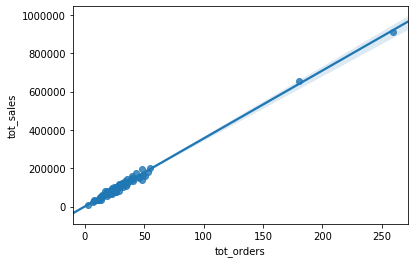

In [13]:
sns.regplot(customer_data['tot_orders'], customer_data['tot_sales'])

Those two customers are making it difficult to read the data. Let's remove them from the dataset temporarily to take a closer look at the rest of the customers.

In [14]:
temp_table = customer_data.drop(['Euro Shopping Channel','Mini Gifts Distributors Ltd.'])

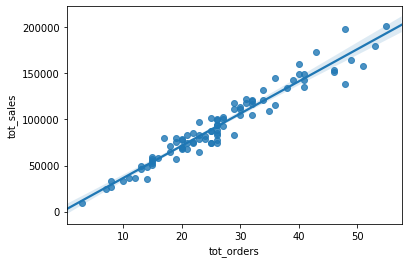

In [15]:
sns.regplot(temp_table['tot_orders'], temp_table['tot_sales'])

As we might expect, total sales and total orders appear to be very closely correlated. Let's confirm that:

In [16]:
print(temp_table.corr())

            tot_orders  tot_sales
tot_orders    1.000000   0.967797
tot_sales     0.967797   1.000000


### Average order value: a possible measure of "profitability"

Customers that are above our trendline are - in theory - more profitable than those below it; that's because they bring in more money with less orders, and therefore less admin/costs are required. We can create a column called "Average Order Value" to provide a figure for each customer.

In [17]:
avg_sales = sales_data.groupby(['CUSTOMERNAME']).mean().sort_values(by=['SALES'],ascending=False).round(2)
customer_data = pd.merge(customer_data, avg_sales, on='CUSTOMERNAME')
customer_data.columns = ['tot_orders','tot_sales','avg_sales']

In [18]:
customer_data.head()

,tot_orders,tot_sales,avg_sales
CUSTOMERNAME,,,
Euro Shopping Channel,259,912294.11,3522.37
Mini Gifts Distributors Ltd.,180,654858.06,3638.10
"Australian Collectors, Co.",55,200995.41,3654.46
La Rochelle Gifts,53,180124.90,3398.58
"AV Stores, Co.",51,157807.81,3094.27


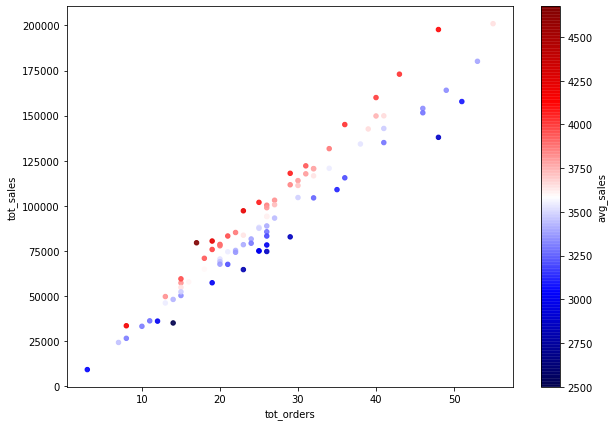

In [19]:
customer_data.drop(['Euro Shopping Channel','Mini Gifts Distributors Ltd.']).plot(kind="scatter", x="tot_orders", y="tot_sales", alpha=0.9,
     figsize=(10,7),
    c="avg_sales", cmap=plt.get_cmap("seismic"), colorbar=True,
    sharex=False)
plt.show()

In the above plot, our most profitable customers are in warmer colors, and our less profitable customers are in cold colors.

Next, we can create a column that assigns a value to each customer based on whether they are more profitable than the mean or less profitable.

One way to measure profitability is average order value. Every order that is processed naturally incurs costs, so we should prefer customers that make fewer, higher value orders.

In [20]:
print('Mean:', np.mean(customer_data['avg_sales']))
print('Standard Deviation:', np.std(customer_data['avg_sales']))

Mean: 3551.3818478260887
Standard Deviation: 371.4417782802849


The average order value is 3551, and the standard deviation is 371. We could classify customers into three brackets:
1. Customers that have an average order value greater than one standard deviation above the mean (Profitable customers)
2. Customers that have an average order value less than one standard deviation away from the mean (Average customers)
3. Customers that have an average order value greater than one standard deviation below the mean (Unprofitable customers)

In [21]:
def label_customer(row):
    if row['avg_sales'] > (np.mean(customer_data['avg_sales'] + np.std(customer_data['avg_sales']))):
        return 'Profitable'
    if row['avg_sales'] < (np.mean(customer_data['avg_sales'] - np.std(customer_data['avg_sales']))):
        return 'Unprofitable'
    return 'Average'   

In [22]:
customer_data['class'] = customer_data.apply(lambda row: label_customer(row), axis=1)

In [23]:
customer_data['class'].value_counts()

Average         63
Profitable      16
Unprofitable    13
Name: class, dtype: int64

We can see that we have 16 profitable customers, 13 unprofitable, and 63 average. Below are our profitable customers:

In [24]:
customer_data[customer_data['class']=="Profitable"].sort_values(by=['avg_sales'], ascending=False)

,tot_orders,tot_sales,avg_sales,class
CUSTOMERNAME,,,,
Super Scale Inc.,17,79472.07,4674.83,Profitable
Mini Caravy,19,80438.48,4233.60,Profitable
"La Corne D'abondance, Co.",23,97203.68,4226.25,Profitable
Royale Belge,8,33440.10,4180.01,Profitable
Muscle Machine Inc,48,197736.94,4119.52,Profitable
Gift Depot Inc.,25,101894.79,4075.79,Profitable
"UK Collectables, Ltd.",29,118008.27,4069.25,Profitable
Danish Wholesale Imports,36,145041.60,4028.93,Profitable
"Dragon Souveniers, Ltd.",43,172989.68,4023.02,Profitable


And below are our least profitable customers:

In [25]:
customer_data[customer_data['class']=="Unprofitable"].sort_values(by=['avg_sales'], ascending=True)

,tot_orders,tot_sales,avg_sales,class
CUSTOMERNAME,,,,
"Bavarian Collectables Imports, Co.",14,34993.92,2499.57,Unprofitable
"Australian Collectables, Ltd",23,64591.46,2808.32,Unprofitable
Signal Gift Stores,29,82751.08,2853.49,Unprofitable
"Royal Canadian Collectables, Ltd.",26,74634.85,2870.57,Unprofitable
Rovelli Gifts,48,137955.72,2874.08,Unprofitable
Marseille Mini Autos,25,74936.14,2997.45,Unprofitable
Petit Auto,25,74972.52,2998.90,Unprofitable
"Double Decker Gift Stores, Ltd",12,36019.04,3001.59,Unprofitable
giftsbymail.co.uk,26,78240.84,3009.26,Unprofitable


So in theory, we would want to prioritize our efforts on our most profitable customers, and spend less time nurturing less profitable customers. We might also want to focus our efforts on acquiring customers that are similar to our profitable customers. But first, we should examine whether the difference between the profitable and average customers is signficant enough to warrant treating them differently.

## 2. Is there a difference between profitable customers and average customers?

Let's test the hypothesis that the average order value for profitable customers is not significantly different from the average order value. 

In [26]:
profitable = customer_data[customer_data['class']=="Profitable"]
ttest_1samp(profitable['avg_sales'],np.mean(customer_data['avg_sales']))

Ttest_1sampResult(statistic=11.440671532245702, pvalue=8.276594505520693e-09)

This small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so we can reject the null hypothesis that there is no difference between the two groups. This suggests that we should treat profitable customers differently.

## 3. Can we characterize profitable customers?

What do profitable customers look like? There are couple of ways we can use the data to characterise our customers:
1. Country
2. What product types they buy
3. What specific products they buy

Let's check the different options in each category to see what we're dealing with.

In [27]:
print(sales_data['COUNTRY'].value_counts().count())
print(sales_data['PRODUCTLINE'].value_counts().count())
print(sales_data['PRODUCTCODE'].value_counts().count())

19
7
109


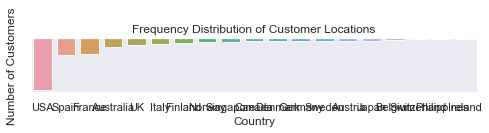

In [28]:
country_count = sales_data['COUNTRY'].value_counts()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15,7)})
sns.palplot(sns.color_palette("husl", 8))
sns.barplot(country_count.index, country_count.values, alpha=0.9)
plt.title('Frequency Distribution of Customer Locations')
plt.ylabel('Number of Customers', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.show()

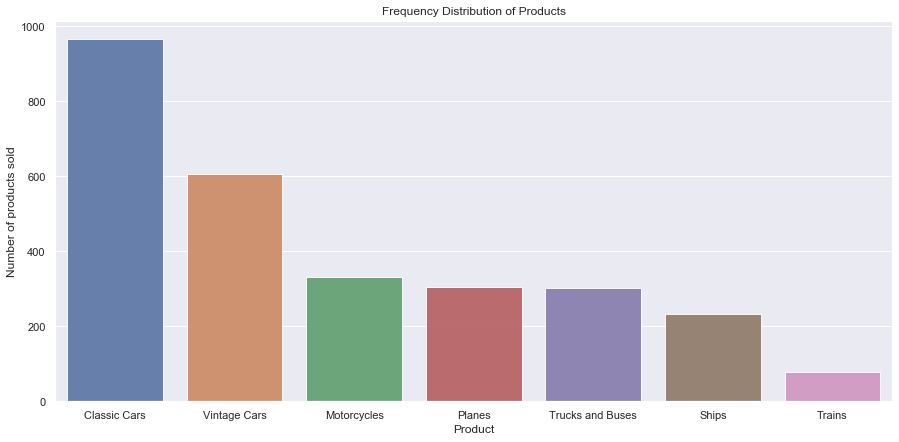

In [29]:
product_count = sales_data['PRODUCTLINE'].value_counts()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15,7)})
sns.barplot(product_count.index, product_count.values, alpha=0.9)
plt.title('Frequency Distribution of Products')
plt.ylabel('Number of products sold', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.show()

We have 19 countries, 7 product types, and 109 different products. For modelling purposes, we shall focus on the first two, because 109 products is likely to be introduce too many characteristics for a model to learn.


We need to convert our categorical data into numerical data to prepare it for machine learning.

#### Preparing Country Data

In [30]:
labels = sales_data['COUNTRY'].astype('category').cat.categories.tolist()
replace_map_comp = {'COUNTRY' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print(replace_map_comp)

{'COUNTRY': {'Australia': 1, 'Austria': 2, 'Belgium': 3, 'Canada': 4, 'Denmark': 5, 'Finland': 6, 'France': 7, 'Germany': 8, 'Ireland': 9, 'Italy': 10, 'Japan': 11, 'Norway': 12, 'Philippines': 13, 'Singapore': 14, 'Spain': 15, 'Sweden': 16, 'Switzerland': 17, 'UK': 18, 'USA': 19}}


In [31]:
sales_data_replace = sales_data.copy()
sales_data_replace.replace(replace_map_comp, inplace=True)

In [32]:
sales_data_replace.head()

,CUSTOMERNAME,SALES,PRODUCTLINE,PRODUCTCODE,COUNTRY,DEALSIZE
ORDERDATE,,,,,,
2003-01-06,Online Diecast Creations Co.,5151.00,Vintage Cars,S18_1749,19,Medium
2003-01-06,Online Diecast Creations Co.,3390.00,Vintage Cars,S18_2248,19,Medium
2003-01-06,Online Diecast Creations Co.,1903.22,Vintage Cars,S18_4409,19,Small
2003-01-06,Online Diecast Creations Co.,1689.03,Vintage Cars,S24_3969,19,Small
2003-01-09,"Blauer See Auto, Co.",1404.00,Vintage Cars,S24_1937,8,Small


#### Preparing Product Data 

In [33]:
product_sales = pd.crosstab(sales_data.CUSTOMERNAME, sales_data.PRODUCTLINE)

In [34]:
product_sales.head()

PRODUCTLINE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",19,0,0,7,3,0,22
Alpha Cognac,4,0,6,7,0,0,3
Amica Models & Co.,4,0,0,3,1,1,17
"Anna's Decorations, Ltd",24,6,0,0,0,9,7
Atelier graphique,4,2,0,0,0,0,1


We need to standardize this data, because what's important is the distribution of products sold across the customers. 

In [35]:
standardized_data = ((pd.DataFrame(preprocessing.scale(product_sales), 
                            index=product_sales.index, 
                            columns=product_sales.columns)).merge(customer_data, 
                                                                  how='inner', 
                                                                  on='CUSTOMERNAME')).merge(sales_data_replace,
                                how='left',
                                on='CUSTOMERNAME').drop_duplicates(subset='CUSTOMERNAME', 
                                                                   keep='first').drop(['PRODUCTLINE','PRODUCTCODE',
                                                                                    'DEALSIZE','tot_orders','tot_sales',
                                                                                    'SALES','avg_sales'],axis=1)
label = standardized_data['class']
standardized_data.drop(labels=['class'], axis=1,inplace = True)
standardized_data.insert(9, 'class', label)
standardized_data = standardized_data.drop('CUSTOMERNAME',axis=1)

In [36]:
standardized_data.head()

,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,COUNTRY,class
0,0.622872,-0.761786,-0.679517,1.139645,1.266027,-0.592820,1.943155,18,Unprofitable
51,-0.477721,-0.761786,0.546278,1.139645,-0.489870,-0.592820,-0.453906,7,Average
71,-0.477721,-0.761786,-0.679517,0.116744,0.095429,-0.411626,1.312350,10,Average
97,0.989737,0.508624,-0.679517,-0.650432,-0.489870,1.037927,0.050739,1,Average
143,-0.477721,-0.338316,-0.679517,-0.650432,-0.489870,-0.592820,-0.706228,7,Average


#### Creating class variable

In [37]:
customer_labels = standardized_data['class'].astype('category').cat.categories.tolist()
replace_map_cust = {'class' : {k: v for k,v in zip(customer_labels,list(range(1,len(customer_labels)+1)))}}
print(replace_map_cust)

{'class': {'Average': 1, 'Profitable': 2, 'Unprofitable': 3}}


In [38]:
standardized_data_replace = standardized_data.copy()
standardized_data_replace.replace(replace_map_cust, inplace=True)

In [39]:
standardized_data_replace.head()

,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,COUNTRY,class
0,0.622872,-0.761786,-0.679517,1.139645,1.266027,-0.592820,1.943155,18,3
51,-0.477721,-0.761786,0.546278,1.139645,-0.489870,-0.592820,-0.453906,7,1
71,-0.477721,-0.761786,-0.679517,0.116744,0.095429,-0.411626,1.312350,10,1
97,0.989737,0.508624,-0.679517,-0.650432,-0.489870,1.037927,0.050739,1,1
143,-0.477721,-0.338316,-0.679517,-0.650432,-0.489870,-0.592820,-0.706228,7,1


In [40]:
standardized_data_replace['class'].value_counts()

1    63
2    16
3    13
Name: class, dtype: int64

In [41]:
X = standardized_data_replace.drop(['class'], axis = 1)
y = standardized_data_replace['class'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

#### Using KNN 

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 4)  # n_neighbors means k
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"4 KNN Accuracy: {round(knn.score(X_test, y_test)*100,2)}%")

4 KNN Accuracy: 71.43%


In [43]:
results = confusion_matrix(y_test, y_pred) 
print(replace_map_cust)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred)) 
print ('Report : ')
print (classification_report(y_test, y_pred))

{'class': {'Average': 1, 'Profitable': 2, 'Unprofitable': 3}}
Confusion Matrix :
[[20  0  1]
 [ 6  0  0]
 [ 1  0  0]]
Accuracy Score : 0.7142857142857143
Report : 
              precision    recall  f1-score   support

           1       0.74      0.95      0.83        21
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1

    accuracy                           0.71        28
   macro avg       0.25      0.32      0.28        28
weighted avg       0.56      0.71      0.62        28



C:\Users\lukes\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Using the KNeighbours classifier, it appears that we can correcrtly classify customers with an accuracy of 76%.

#### Using Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [45]:
from sklearn import metrics
print(f"Random Forest Accuracy: {round(metrics.accuracy_score(y_test, y_pred)*100,2)}%")

Random Forest Accuracy: 75.0%


In [46]:
results = confusion_matrix(y_test, y_pred) 
print(replace_map_cust)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred)) 
print ('Report : ')
print (classification_report(y_test, y_pred))

{'class': {'Average': 1, 'Profitable': 2, 'Unprofitable': 3}}
Confusion Matrix :
[[19  1  1]
 [ 5  1  0]
 [ 0  0  1]]
Accuracy Score : 0.75
Report : 
              precision    recall  f1-score   support

           1       0.79      0.90      0.84        21
           2       0.50      0.17      0.25         6
           3       0.50      1.00      0.67         1

    accuracy                           0.75        28
   macro avg       0.60      0.69      0.59        28
weighted avg       0.72      0.75      0.71        28



We can see which features are most important to our classification model:

In [47]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [48]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

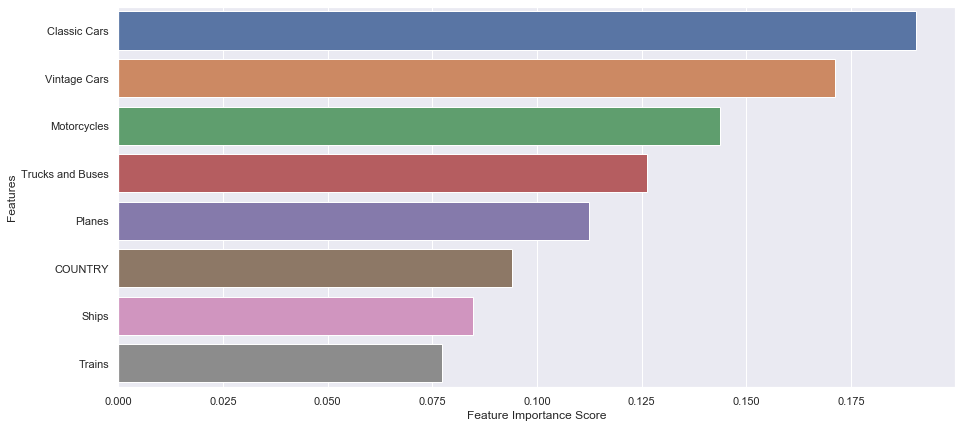

In [49]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

## 4. Can we predict if a new customer will be profitable? 

For this scenario, we will see if we can predict if a company will profitable in two years, based on an analysis of their behaviour during the first year. 

In [50]:
data['YEAR_ID'].value_counts().index

Int64Index([2004, 2003, 2005], dtype='int64')

We can train our model on data just from year 2003 to see if it can predict who are the profitable custoemrs in 2005.

In [51]:
sales_data_2003 = data[data['YEAR_ID']==2003].drop(['ORDERNUMBER','QUANTITYORDERED','PRICEEACH','ORDERLINENUMBER','STATUS','QTR_ID',
                       'MSRP','PHONE','ADDRESSLINE1','ADDRESSLINE2','CITY','STATE','POSTALCODE',
                       'TERRITORY','CONTACTLASTNAME','CONTACTFIRSTNAME','MONTH_ID',
                       'YEAR_ID'],axis=1)
column_order = ['ORDERDATE','CUSTOMERNAME',
               'SALES','PRODUCTLINE','PRODUCTCODE',
               'COUNTRY','DEALSIZE']
sales_data_2003 = sales_data_2003[column_order]
sales_data_2003['ORDERDATE']= pd.to_datetime(sales_data_2003['ORDERDATE'])
sales_data_2003 = sales_data_2003.sort_values(by=['ORDERDATE'], ascending=True)
sales_data_2003 = sales_data_2003.set_index('ORDERDATE')
tot_sales_2003 = sales_data_2003.groupby(['CUSTOMERNAME']).sum().sort_values(by=['SALES'],ascending=False)
tot_orders_2003 = sales_data_2003.groupby(['CUSTOMERNAME']).count().sort_values(by=['SALES'],ascending=False).drop(['PRODUCTLINE',
                                                                                                          'PRODUCTCODE',
                                                                                                          'COUNTRY',
                                                                                                          'DEALSIZE'],axis=1)

In [52]:
customer_data_2003 = pd.merge(tot_orders_2003, tot_sales_2003, on='CUSTOMERNAME')
customer_data_2003.columns = ['tot_orders_2003','tot_sales_2003']

In [53]:
avg_sales_2003 = sales_data_2003.groupby(['CUSTOMERNAME']).mean().sort_values(by=['SALES'],ascending=False).round(2)
customer_data_2003 = pd.merge(customer_data_2003, avg_sales_2003, on='CUSTOMERNAME')
customer_data_2003.columns = ['tot_orders_2003','tot_sales_2003','avg_sales_2003']

After creating our dataframe for 2003, we apply the customer labels that we created analyzing the global data.

In [54]:
customer_data_2003['class'] = customer_data['class']

#### Standardize Data 

In [55]:
labels = sales_data_2003['COUNTRY'].astype('category').cat.categories.tolist()
replace_map_comp = {'COUNTRY' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
sales_data_2003_replace = sales_data_2003.copy()
sales_data_2003_replace.replace(replace_map_comp, inplace=True)
product_sales_2003 = pd.crosstab(sales_data_2003.CUSTOMERNAME, sales_data_2003.PRODUCTLINE)
standardized_data_2003 = ((pd.DataFrame(preprocessing.scale(product_sales_2003), 
                            index=product_sales_2003.index, 
                            columns=product_sales_2003.columns)).merge(customer_data_2003, 
                                                                  how='inner', 
                                                                  on='CUSTOMERNAME')).merge(sales_data_2003_replace,
                                how='left',
                                on='CUSTOMERNAME').drop_duplicates(subset='CUSTOMERNAME', 
                                                                   keep='first').drop(['PRODUCTLINE','PRODUCTCODE',
                                                                                    'DEALSIZE','tot_orders_2003',
                                                                                    'tot_sales_2003',
                                                                                    'SALES','avg_sales_2003'],axis=1)

In [56]:
label = standardized_data_2003['class']
standardized_data_2003.drop(labels=['class'], axis=1,inplace = True)
standardized_data_2003.insert(9, 'class', label)
standardized_data_2003 = standardized_data_2003.drop('CUSTOMERNAME',axis=1)
customer_labels = standardized_data_2003['class'].astype('category').cat.categories.tolist()
replace_map_cust = {'class' : {k: v for k,v in zip(customer_labels,list(range(1,len(customer_labels)+1)))}}
standardized_data_2003_replace = standardized_data_2003.copy()
standardized_data_2003_replace.replace(replace_map_cust, inplace=True)
X = standardized_data_2003_replace.drop(['class'], axis = 1)
y = standardized_data_2003_replace['class'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

#### Applying KNN and Random Forest classifiers to the new data.

In [57]:
knn = KNeighborsClassifier(n_neighbors = 4)  # n_neighbors means k
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"4 KNN Accuracy: {round(knn.score(X_test, y_test)*100,2)}%")

4 KNN Accuracy: 66.67%


In [58]:
results = confusion_matrix(y_test, y_pred) 
print(replace_map_cust)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred)) 
print ('Report : ')
print (classification_report(y_test, y_pred))

{'class': {'Average': 1, 'Profitable': 2, 'Unprofitable': 3}}
Confusion Matrix :
[[14  1  0]
 [ 3  0  0]
 [ 3  0  0]]
Accuracy Score : 0.6666666666666666
Report : 
              precision    recall  f1-score   support

           1       0.70      0.93      0.80        15
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3

    accuracy                           0.67        21
   macro avg       0.23      0.31      0.27        21
weighted avg       0.50      0.67      0.57        21



C:\Users\lukes\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(f"Random Forest Accuracy: {round(metrics.accuracy_score(y_test, y_pred)*100,2)}%")

Random Forest Accuracy: 71.43%


In [60]:
results = confusion_matrix(y_test, y_pred) 
print(replace_map_cust)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred)) 
print ('Report : ')
print (classification_report(y_test, y_pred))

{'class': {'Average': 1, 'Profitable': 2, 'Unprofitable': 3}}
Confusion Matrix :
[[14  1  0]
 [ 3  0  0]
 [ 2  0  1]]
Accuracy Score : 0.7142857142857143
Report : 
              precision    recall  f1-score   support

           1       0.74      0.93      0.82        15
           2       0.00      0.00      0.00         3
           3       1.00      0.33      0.50         3

    accuracy                           0.71        21
   macro avg       0.58      0.42      0.44        21
weighted avg       0.67      0.71      0.66        21



Despite our high accuracy scores, our models are poor at predicting profitable and unprofitable customers. It seems that with the data that we have, it will be hard to predict profitable customers by products that they buy.

## Tracking LTV rather than profitability

Another option that we have is to look at general purchasing data to calculate customer LTV (Life Time Value). Let's recap the information we have in the sales database:

In [61]:
sales_data.head()

,CUSTOMERNAME,SALES,PRODUCTLINE,PRODUCTCODE,COUNTRY,DEALSIZE
ORDERDATE,,,,,,
2003-01-06,Online Diecast Creations Co.,5151.00,Vintage Cars,S18_1749,USA,Medium
2003-01-06,Online Diecast Creations Co.,3390.00,Vintage Cars,S18_2248,USA,Medium
2003-01-06,Online Diecast Creations Co.,1903.22,Vintage Cars,S18_4409,USA,Small
2003-01-06,Online Diecast Creations Co.,1689.03,Vintage Cars,S24_3969,USA,Small
2003-01-09,"Blauer See Auto, Co.",1404.00,Vintage Cars,S24_1937,Germany,Small


#### Calculating Recency

In [62]:
customers = pd.DataFrame(sales_data['CUSTOMERNAME'].unique())
last_purchase = sales_data.groupby('CUSTOMERNAME').idxmax()
last_purchase.columns = ['LASTPURCHASEDATE']
last_purchase['RECENCY'] = (last_purchase['LASTPURCHASEDATE'].max() - last_purchase['LASTPURCHASEDATE']).dt.days

In [63]:
last_purchase.head()

,LASTPURCHASEDATE,RECENCY
CUSTOMERNAME,,
"AV Stores, Co.",2004-11-17,195
Alpha Cognac,2003-07-04,697
Amica Models & Co.,2004-09-09,264
"Anna's Decorations, Ltd",2005-01-20,131
Atelier graphique,2003-05-20,742


#### Plot Recency 

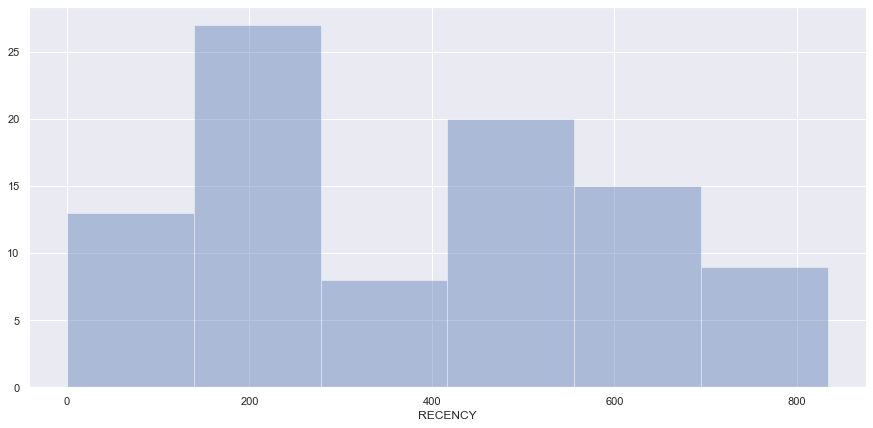

In [64]:
sns.distplot(last_purchase['RECENCY'],kde = False)
plt.show()

#### Apply K means clustering to assign recency score

First, we use the elbow method to tell us the optimum cluster number.

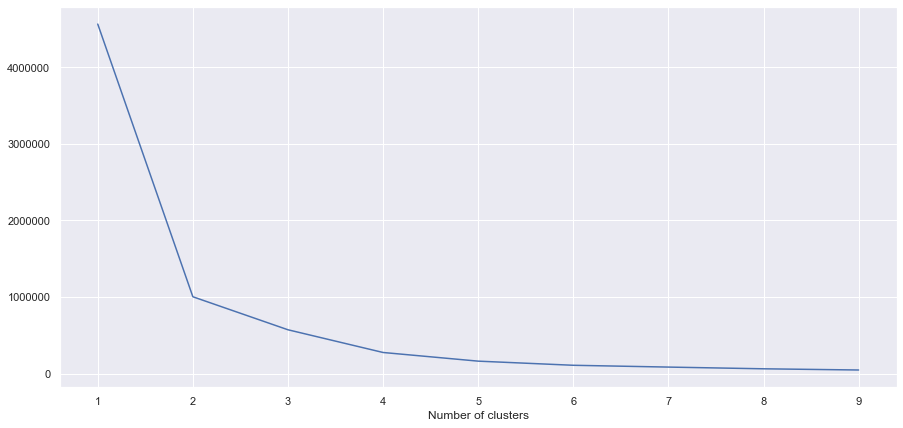

In [65]:
sse={}
recency = last_purchase[['RECENCY']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [66]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(last_purchase[['RECENCY']])
last_purchase['RecencyCluster'] = kmeans.predict(last_purchase[['RECENCY']])

In [67]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [68]:
last_purchase.head()

,LASTPURCHASEDATE,RECENCY,RecencyCluster
CUSTOMERNAME,,,
"AV Stores, Co.",2004-11-17,195,0
Alpha Cognac,2003-07-04,697,1
Amica Models & Co.,2004-09-09,264,0
"Anna's Decorations, Ltd",2005-01-20,131,3
Atelier graphique,2003-05-20,742,1


In [69]:
last_purchase_temp = order_cluster('RecencyCluster', 'RECENCY',last_purchase,True).merge(
    last_purchase.reset_index()['CUSTOMERNAME'], left_index=True, right_index=True)
last_purchase_temp['RecencyCluster'] = last_purchase_temp['RecencyCluster'].replace({0: 3, 1: 2,2:1,3:0})

In [70]:
last_purchase_temp.groupby('RecencyCluster').describe()

RECENCY                                                      \
                 count        mean        std    min    25%    50%     75%   
RecencyCluster                                                               
0                 12.0  739.250000  60.929356  634.0  694.0  735.0  790.75   
1                 33.0  522.363636  60.861430  391.0  474.0  539.0  564.00   
2                 32.0  242.562500  51.543241  173.0  204.0  229.5  268.00   
3                 15.0   67.266667  49.060410    0.0   28.0   47.0  114.50   

                       
                  max  
RecencyCluster         
0               834.0  
1               620.0  
2               378.0  
3               141.0

We can see that the customers in our clusters display very different characteristics, which is good!

#### Frequency

We already have total order data gathered, so we can add this to our dataframe. We need to assign a score in a similar way to how we did for recency.

In [71]:
tot_orders.head()

,SALES
CUSTOMERNAME,
Euro Shopping Channel,259
Mini Gifts Distributors Ltd.,180
"Australian Collectors, Co.",55
La Rochelle Gifts,53
"AV Stores, Co.",51


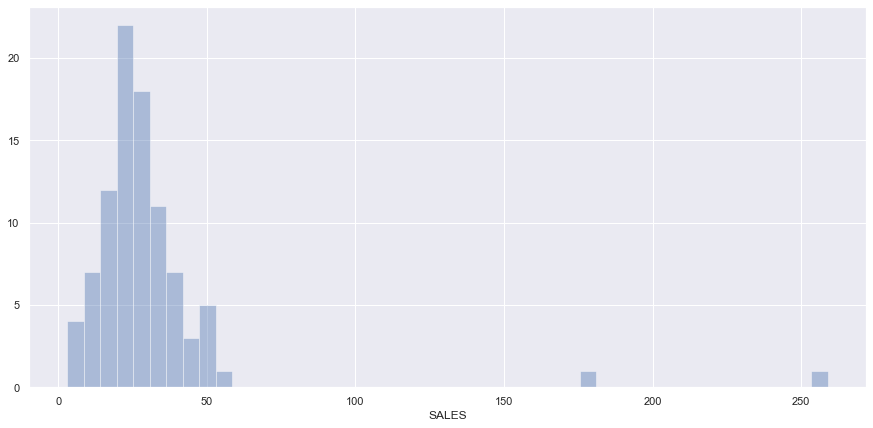

In [72]:
sns.distplot(tot_orders['SALES'],kde = False)
plt.show()

In [73]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tot_orders[['SALES']])
tot_orders['FrequencyCluster'] = kmeans.predict(tot_orders[['SALES']])

In [74]:
tot_orders_temp = order_cluster('FrequencyCluster', 'SALES',tot_orders,True).merge(
    tot_orders.reset_index()['CUSTOMERNAME'], left_index=True, right_index=True)

In [75]:
tot_orders_temp.groupby('FrequencyCluster')['SALES'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,63.0,20.634921,6.373589,3.0,15.5,22.0,26.0,30.0
1,27.0,40.148148,7.230830,31.0,34.0,40.0,46.0,55.0
2,1.0,180.000000,NaN,180.0,180.0,180.0,180.0,180.0
3,1.0,259.000000,NaN,259.0,259.0,259.0,259.0,259.0


#### Revenue

Finally, let's repear the process for total sales.

In [76]:
tot_sales.head()

,SALES
CUSTOMERNAME,
Euro Shopping Channel,912294.11
Mini Gifts Distributors Ltd.,654858.06
"Australian Collectors, Co.",200995.41
Muscle Machine Inc,197736.94
La Rochelle Gifts,180124.90


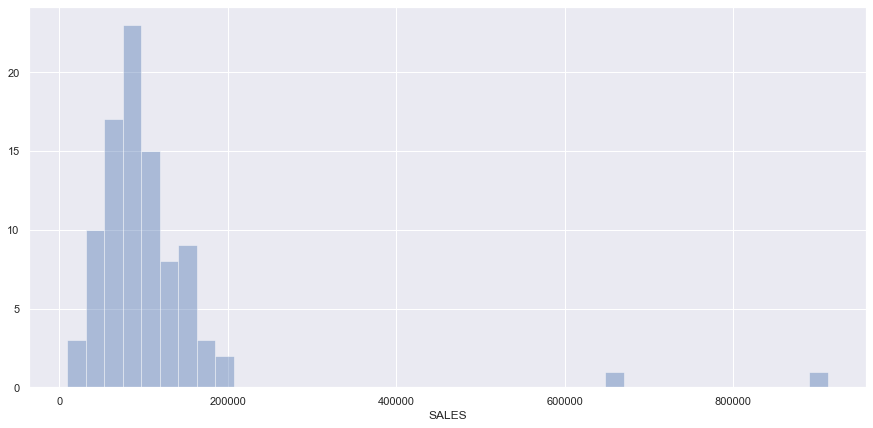

In [77]:
sns.distplot(tot_sales['SALES'],kde = False)
plt.show()

In [78]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tot_sales[['SALES']])
tot_sales['RevenueCluster'] = kmeans.predict(tot_sales[['SALES']])

In [79]:
tot_sales_temp = order_cluster('RevenueCluster', 'SALES',tot_sales,True).merge(
    tot_sales.reset_index()['CUSTOMERNAME'], left_index=True, right_index=True)

In [80]:
tot_sales_temp.groupby('RevenueCluster')['SALES'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,60.0,70988.526667,22380.899919,9129.35,57270.3050,75105.72,85267.6900,104561.96
1,30.0,140205.502667,25315.713469,108951.13,118646.8875,136499.33,153389.8425,200995.41
2,1.0,654858.060000,NaN,654858.06,654858.0600,654858.06,654858.0600,654858.06
3,1.0,912294.110000,NaN,912294.11,912294.1100,912294.11,912294.1100,912294.11


#### Calculating Overall Score

In [81]:
display(last_purchase_temp.head(1))
display(tot_orders_temp.head(1))
display(tot_sales_temp.head(1))

,LASTPURCHASEDATE,RECENCY,RecencyCluster,CUSTOMERNAME
0,2004-11-17,195,2,"AV Stores, Co."


,SALES,FrequencyCluster,CUSTOMERNAME
0,259,3,Euro Shopping Channel


,SALES,RevenueCluster,CUSTOMERNAME
0,912294.11,3,Euro Shopping Channel


First we'll create a new dataframe to contain our LTV values:

In [82]:
ltv = last_purchase_temp[['CUSTOMERNAME','RecencyCluster','RECENCY']].merge(tot_orders_temp[['CUSTOMERNAME','FrequencyCluster','SALES']], 
                                                                  how='inner', 
                                                                  on='CUSTOMERNAME').merge(
                                                                tot_sales_temp[['CUSTOMERNAME','RevenueCluster','SALES']],
                                                                how='inner', on='CUSTOMERNAME')

Next, we can create an 'Overall Score' column and assign a 'Value' label to each customer based on their score.

In [83]:
ltv['OverallScore'] = ltv['RecencyCluster'] + ltv['FrequencyCluster'] + ltv['RevenueCluster']
ltv['Value'] = 'Low'
ltv.loc[ltv['OverallScore']>2,'Value'] = 'Mid' 
ltv.loc[ltv['OverallScore']>4,'Value'] = 'High' 
ltv.columns = ['customer','recency_cluster','recency','frequency_cluster',
        'orders','revenue_cluster','revenue','overall_score','value']

In [84]:
ltv.head(100)

,customer,recency_cluster,recency,frequency_cluster,orders,revenue_cluster,revenue,overall_score,value
0,"AV Stores, Co.",2,195,1,51,1,157807.81,4,Mid
1,Alpha Cognac,2,264,0,20,0,70488.44,2,Low
2,Amica Models & Co.,2,333,0,26,0,94117.26,2,Low
3,"Anna's Decorations, Ltd",2,232,1,46,1,153996.13,4,Mid
4,Atelier graphique,2,266,0,7,0,24179.96,2,Low
5,"Australian Collectables, Ltd",2,207,0,23,0,64591.46,2,Low
6,"Australian Collectors, Co.",2,258,1,55,1,200995.41,4,Mid
7,"Australian Gift Network, Co",2,229,0,15,0,59469.12,2,Low
8,Auto Assoc. & Cie.,2,315,0,18,0,64834.32,2,Low
9,Auto Canal Petit,2,188,0,27,0,93170.66,2,Low


The scoring below shows us that customers with score 8 are our best customers whereas 0 are the worst.

In [85]:
ltv.groupby('overall_score')['recency','orders','revenue'].mean()

,recency,orders,revenue
overall_score,,,
0,751.500000,23.000000,84032.191250
1,521.631579,21.894737,76336.016316
2,319.000000,20.931034,73635.618621
3,306.428571,29.761905,105545.416667
4,230.888889,40.777778,148896.193333
5,109.250000,46.250000,162720.602500
6,742.000000,259.000000,912294.110000
7,14.000000,180.000000,654858.060000


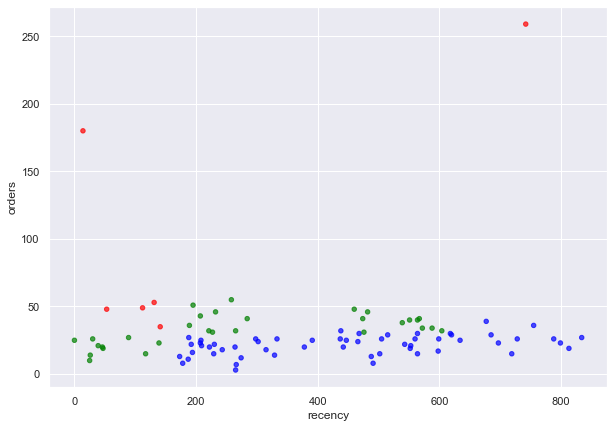

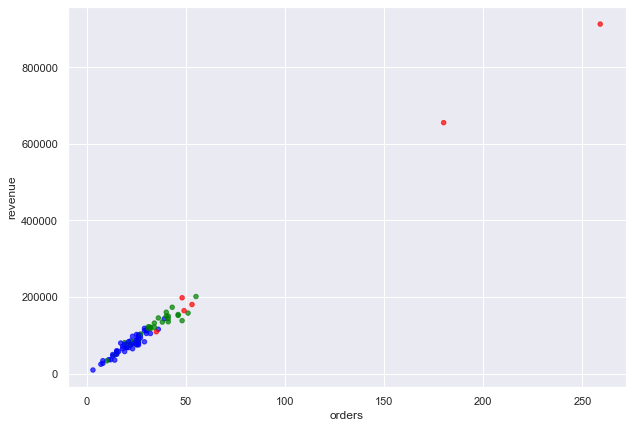

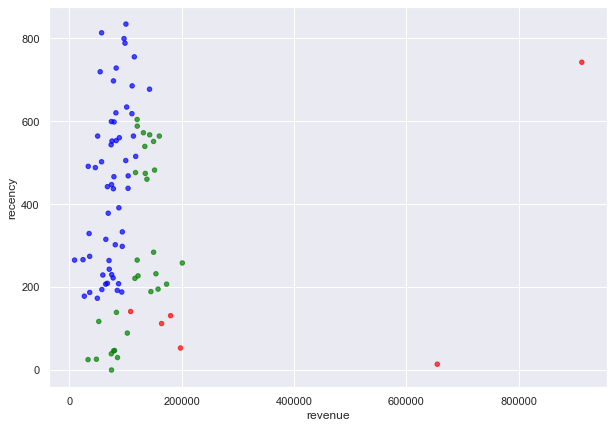

In [86]:
colors = {'High':'red', 'Mid':'green', 'Low':'blue'}
ltv.plot(kind="scatter", x="recency", y="orders", alpha=0.7,
    #label="population", 
    figsize=(10,7),
    c=ltv['value'].apply(lambda x: colors[x]),
    sharex=False)
ltv.plot(kind="scatter", x="orders", y="revenue", alpha=0.7,
    #label="population", 
    figsize=(10,7),
    c=ltv['value'].apply(lambda x: colors[x]),
    sharex=False)
ltv.plot(kind="scatter", x="revenue", y="recency", alpha=0.7,
    #label="population", 
    figsize=(10,7),
    c=ltv['value'].apply(lambda x: colors[x]),
    sharex=False)
plt.show()